# **Define Problem**

The aim of this study is to **explore the correlation between weather variables and individual consumption behaviors** through various analytical techniques, encompassing LST, LGBM, Simple RNN, and Ridge Regression.

This analysis holds **significant potential in aiding emerging Small and Medium-sized Enterprises (UMKM) within the food and beverage industry**. By leveraging weather insights, these businesses can optimize their resource allocation and inventory management. This translates into better-informed decisions, **preventing unnecessary stockpiling of ingredients during periods of reduced demand**. Ultimately, this study has the potential to empower UMKM owners to navigate their ventures more effectively, **minimizing waste and maximizing operational efficiency.**

In [1]:
# Import other necessary libraries
import numpy as np
import pandas as pd

# Import libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Import libraries for performance metrics and data preprocessing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Import libraries for building neural network models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# Import libraries for linear regression models
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# Import library for LightGBM
import lightgbm as lgb

# Import the TimeSeriesSplit class from scikit-learn for time series cross-validation
from sklearn.model_selection import TimeSeriesSplit

# **Collecting Data**

The dataset utilized in this analysis comprises two main components: weather data and sales data, each serving a specific purpose. The investigation is centered around the city of Tangerang, as both datasets are inherently linked to this region. The sales data originates from a local cafe situated in Tangerang and is extracted directly from the establishment's Point of Sales (POS) system, which operates through the odoo platform. This dataset provides comprehensive insights into the cafe's daily sales performance. On the other hand, the weather data is sourced from NASA Power, a reliable data repository renowned for its meteorological information. This weather dataset encompasses various weather-related parameters such as maximum temperature, minimum temperature, relative humidity, wind speed, and average temperature. By combining these two distinct datasets, we aim to unearth potential correlations and insights between weather patterns and sales trends within the specific context of Tangerang

**📍Please be aware** that the sales data used in this study is confidential and cannot be shared openly due to its sensitive nature. If you are interested in accessing this data for insights or validation, please contact me privately via email.

In [2]:
# Load sales data from a CSV file into a DataFrame
df_sales = pd.read_csv("2019-2023(sales).csv")

# Load weather data from a CSV file into a DataFrame
df_weathers = pd.read_csv("2000-2023(weather).csv")

In [3]:
# Display the DataFrame containing sales data
df_sales

,Date,Point of Sale
0,1-10-2019,"706,000"
1,2-10-2019,"1,527,550"
2,3-10-2019,"1,415,900"
3,4-10-2019,"1,588,400"
4,5-10-2019,"2,111,000"
...,...,...
603,27-05-2023,"313,200"
604,28-05-2023,"367,400"
605,29-05-2023,"477,000"
606,30-05-2023,"441,900"


In [4]:
# Display the DataFrame containing weathers data
df_weathers

,DATE,MAX_TEMP,MIN_TEMP,RH_DAILY,WS_MAX,AVG_TEMP,AVG_WS
0,01-01-2000,29.24,25.15,83.94,5.03,27.195,3.970
1,02-01-2000,28.77,25.45,87.25,5.63,27.110,4.325
2,03-01-2000,27.23,24.98,90.06,4.55,26.105,3.375
3,04-01-2000,28.21,24.50,86.56,3.17,26.355,2.280
4,05-01-2000,28.60,25.25,87.94,5.76,26.925,4.030
...,...,...,...,...,...,...,...
8547,27-05-2023,29.40,26.26,81.12,4.41,27.830,2.855
8548,28-05-2023,30.01,26.48,79.38,3.05,28.245,2.000
8549,29-05-2023,30.43,26.90,80.06,2.99,28.665,2.000
8550,30-05-2023,30.26,26.47,79.38,4.27,28.365,2.840


# **Preprocessing**

In [5]:
# Convert the 'Date' column to datetime format

df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales.set_index('Date', inplace=True)

df_weathers['DATE'] = pd.to_datetime(df_weathers['DATE'], format='%d-%m-%Y')
df_weathers.set_index('DATE', inplace=True)


In [7]:
# Combine the sales and weather DataFrames based on their indices
df_combined = pd.merge(df_sales, df_weathers, left_index=True, right_index=True)

# Rename the 'Point of Sale' column to 'SALES' in the combined DataFrame
df_combined.rename(columns={'Point of Sale': 'SALES'}, inplace=True)

In [8]:
# Remove commas from the 'SALES' column and convert it to float data type
df_combined['SALES'] = df_combined['SALES'].str.replace(',', '').astype(float)

# Display the updated combined DataFrame
df_combined


,SALES,MAX_TEMP,MIN_TEMP,RH_DAILY,WS_MAX,AVG_TEMP,AVG_WS
2019-10-01,706000.0,32.30,25.27,71.44,5.11,28.785,3.595
2019-10-02,1527550.0,32.37,25.59,70.25,5.76,28.980,3.815
2019-10-03,1415900.0,32.45,26.32,70.25,5.07,29.385,3.045
2019-10-04,1588400.0,32.61,25.83,72.31,6.09,29.220,3.865
2019-10-05,2111000.0,32.87,25.19,67.25,5.95,29.030,4.060
...,...,...,...,...,...,...,...
2023-05-27,313200.0,29.40,26.26,81.12,4.41,27.830,2.855
2023-05-28,367400.0,30.01,26.48,79.38,3.05,28.245,2.000
2023-05-29,477000.0,30.43,26.90,80.06,2.99,28.665,2.000
2023-05-30,441900.0,30.26,26.47,79.38,4.27,28.365,2.840


In [9]:
# Remove commas from the 'Point of Sale' column and convert it to float data type
df_sales['Point of Sale'] = df_sales['Point of Sale'].str.replace(',', '').astype(float)

In [10]:
# Display the DataFrame containing sales data
df_sales

,Point of Sale
Date,
2019-10-01,706000.0
2019-10-02,1527550.0
2019-10-03,1415900.0
2019-10-04,1588400.0
2019-10-05,2111000.0
...,...
2023-05-27,313200.0
2023-05-28,367400.0
2023-05-29,477000.0


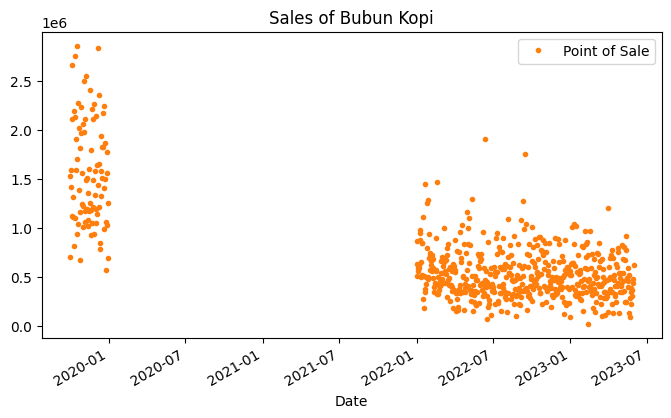

In [11]:
# Create a color palette for visualization
color_pal = sns.color_palette()

# Plot the sales data using a scatter plot
df_sales.plot(style='.',
              figsize=(8, 4.5),
              color=color_pal[1],
              title='Sales of Bubun Kopi')

# Set the default plot style
plt.style.use('default')

# Display the plot
plt.show()

In [12]:
# split data training dan testing
train_df = df_combined[(df_combined.index.year < 2023) | ((df_combined.index.year == 2023) & (df_combined.index.month < 2))]
test_df = df_combined[(df_combined.index.year > 2023) | ((df_combined.index.year == 2023) & (df_combined.index.month >= 2))]

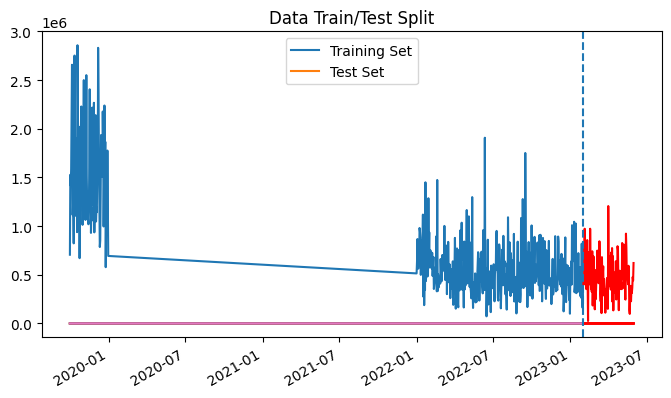

In [13]:
# Create a subplot with a specific figure size
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot the training data using a line plot and label it as 'Training Set'
train_df.plot(ax=ax, label='Training Set', title='Data Train/Test Split')

# Plot the test data using a line plot and label it as 'Test Set'
test_df.plot(ax=ax, label='Test Set', color='red')

# Add a vertical dashed line at '2023-02' to indicate the test set start
ax.axvline('2023-02', ls='--')

# Add legends to the plot
ax.legend(['Training Set', 'Test Set'])

# Display the plot
plt.show()

In [14]:
# Display the dimensions (number of rows and columns) of the training DataFrame
train_df.shape

(488, 7)

In [15]:
# Display the dimensions (number of rows and columns) of the testing DataFrame
test_df.shape

(120, 7)

In [16]:
# List of dates to be set as putlier
tanggal_hapus = ['2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17']

# Set the 'SALES' values to None for the specified dates in the test DataFrame
test_df.loc[test_df.index.isin(tanggal_hapus), 'SALES'] = None

# Filter test_df to display only rows with the deleted dates
filtered_test_df = test_df[test_df.index.isin(tanggal_hapus)]

# Display the filtered test DataFrame
print(filtered_test_df)

            SALES  MAX_TEMP  MIN_TEMP  RH_DAILY  WS_MAX  AVG_TEMP  AVG_WS
2023-02-13    NaN     28.29     25.35     87.00    6.00    26.820   4.550
2023-02-14    NaN     28.51     25.81     86.25    6.27    27.160   5.005
2023-02-15    NaN     28.28     25.59     87.31    6.16    26.935   5.070
2023-02-16    NaN     28.15     25.16     87.44    6.38    26.655   4.990
2023-02-17    NaN     28.37     24.87     86.44    4.44    26.620   3.180


In [17]:
# Forward fill missing values in the test DataFrame
test_df.ffill(inplace=True)

<ipython-input-17-9518b713bcdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.ffill(inplace=True)


Using forward filling, missing values will be filled with the nearest available value from above, making the DataFrame more complete and suitable for further analysis.

In [18]:
# Filter test_df to display only rows with the deleted dates
filtered_test_df = test_df[test_df.index.isin(tanggal_hapus)]

# Display the filtered test DataFrame
print(filtered_test_df)

              SALES  MAX_TEMP  MIN_TEMP  RH_DAILY  WS_MAX  AVG_TEMP  AVG_WS
2023-02-13  25000.0     28.29     25.35     87.00    6.00    26.820   4.550
2023-02-14  25000.0     28.51     25.81     86.25    6.27    27.160   5.005
2023-02-15  25000.0     28.28     25.59     87.31    6.16    26.935   5.070
2023-02-16  25000.0     28.15     25.16     87.44    6.38    26.655   4.990
2023-02-17  25000.0     28.37     24.87     86.44    4.44    26.620   3.180


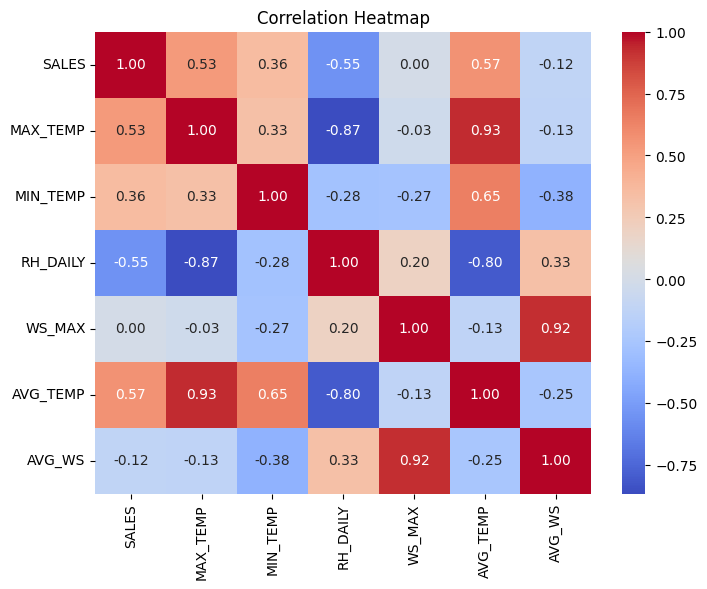

In [19]:
# Calculate the Pearson correlation matrix for the training DataFrame
corr_matrix = train_df.corr(method = 'pearson')

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f") #.2f itu buat kasih tampil 2 titik stlh koma.
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Separate the features (X) and the target variable (y)
X = df_combined.drop('SALES', axis=1)
y = df_combined['SALES']

# Perform feature selection using correlation analysis
selector = SelectKBest(score_func=f_regression, k=4)
X_new = selector.fit_transform(X, y)

# Display the selected features
selected_features = X.columns[selector.get_support()]
print("Selected features:")
print(selected_features)

Selected features:
Index(['MAX_TEMP', 'MIN_TEMP', 'RH_DAILY', 'AVG_TEMP'], dtype='object')


In [21]:
# Define a function to calculate and display regression evaluation metrics
def calculate_metrics(actual, predict):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual, predict)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual, predict)

    # Calculate R-squared (R2)
    r2 = r2_score(actual, predict)

    # Display the calculated metrics
    print('Mean Absolute Error (MAE):', mae)
    print('Mean Absolute Percentage Error (MAPE):', mape)
    print('R-squared (R2):', r2)

In [22]:
# Define a function to create a scatter plot comparing predicted and actual values
def plot_predictions(date, predict, actual, title):
    # Create a scatter plot
    plt.figure(figsize=(13, 7))
    plt.scatter(date, predict, color='red', label='Predict')
    plt.scatter(date, actual, color='blue', label='Actual')
    plt.xlabel('Date')
    plt.rcParams['font.size'] = 18
    plt.ylabel('Sales')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [23]:
# Prepare X and y for training and testing
X_train = train_df[selected_features]  # Selecting only the selected features for training
y_train = train_df['SALES']  # Target variable for training

X_test = test_df[selected_features]  # Selecting only the selected features for testing
y_test = test_df['SALES']  # Target variable for testing

In [24]:
X_train

,MAX_TEMP,MIN_TEMP,RH_DAILY,AVG_TEMP
2019-10-01,32.30,25.27,71.44,28.785
2019-10-02,32.37,25.59,70.25,28.980
2019-10-03,32.45,26.32,70.25,29.385
2019-10-04,32.61,25.83,72.31,29.220
2019-10-05,32.87,25.19,67.25,29.030
...,...,...,...,...
2023-01-27,26.77,25.14,91.19,25.955
2023-01-28,26.62,25.09,90.94,25.855
2023-01-29,27.83,25.11,87.69,26.470
2023-01-30,27.61,25.69,87.88,26.650


In [25]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on training data and testing data
scaler.fit(X_train)
scaler.fit(X_test)

# Transform the training data using the scaler
X_train_scaled = scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = scaler.transform(X_test)

# **Modeling**

In this modeling phase, we will analyze the relationship between weather data and consumption patterns using four different models: LSTM (Long Short-Term Memory), LightGBM, Ridge Regression, and Simple RNN. The objective of this analysis is to predict consumption patterns while considering weather factors, with the aim of gaining deeper insights into the factors influencing sales performance.

# **LGBM**

In [26]:
# Create a LightGBM Dataset for training
d_train = lgb.Dataset(X_train, label=y_train)

# Set LightGBM model parameters
lgbm_params = {
    'learning_rate': 0.01,
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'lambda_l1': 0.5,
    'lambda_l2': 0.3,
}

# Create a LightGBM model using the specified parameters
model = lgb.train(lgbm_params, d_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 488, number of used features: 4
[LightGBM] [Info] Start training from score 734688.661885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [27]:
# Define a function for time series cross-validation using LightGBM
def perform_time_series_cv(X_train, y_train, lgbm_params, k):

    # Initialize a TimeSeriesSplit object with 'k' splits
    tscv = TimeSeriesSplit(n_splits=k)
    scores = []
    cv_ranges = []

    # Iterate over the cross-validation splits
    for train_index, test_index in tscv.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        d_train_cv = lgb.Dataset(X_train_cv, label=y_train_cv)
        model = lgb.train(lgbm_params, d_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        score = mean_absolute_error(y_test_cv, y_pred_cv)
        scores.append(score)

        train_range = (X_train.index[train_index[0]], X_train.index[train_index[-1]])
        test_range = (X_train.index[test_index[0]], X_train.index[test_index[-1]])
        cv_ranges.append((train_range, test_range))

    # Calculate the mean of MAE scores
    mean_mae = np.mean(scores)

    # Print the train and test time periods for each fold
    for i, cv_range in enumerate(cv_ranges):
        print(f"Cross-Validation {i+1} Train Range: {cv_range[0]}")
        print(f"Cross-Validation {i+1} Test Range: {cv_range[1]}")
        print()

    # Print the MAE scores and mean MAE
    print("MAE Scores:", scores)
    print("Mean MAE:", mean_mae)

    # Return MAE scores, mean MAE, and the number of splits 'k'
    return scores, mean_mae, k

In [28]:
# Perform time series cross-validation with 5 splits using LightGBM
scores, mean_mae, k = perform_time_series_cv(X_train, y_train, lgbm_params, 5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 4
[LightGBM] [Info] Start training from score 1590146.987952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

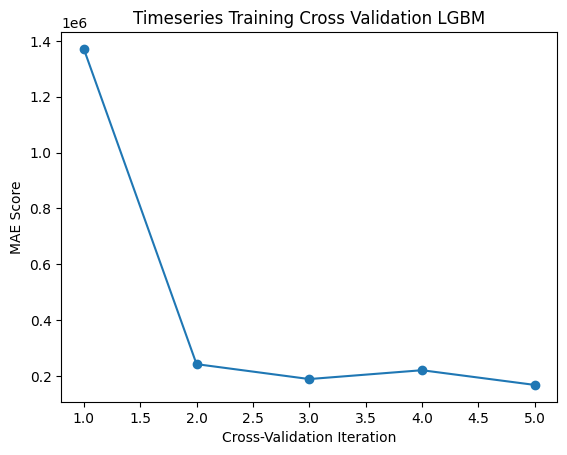

In [29]:
# Plot MAE Scores based on cross-validation iterations
plt.plot(np.arange(1, k+1), scores, marker='o')
plt.xlabel('Cross-Validation Iteration')
plt.ylabel('MAE Score')
plt.title('Timeseries Training Cross Validation LGBM')
plt.show()

In [30]:
# Make predictions on the testing data using the trained model
y_test_pred = model.predict(X_test)

# Calculate and display evaluation metrics for the predicted values
calculate_metrics(y_test, y_test_pred)

Mean Absolute Error (MAE): 177178.66733378364
Mean Absolute Percentage Error (MAPE): 1.2056459658898013
R-squared (R2): -0.050034456933449434


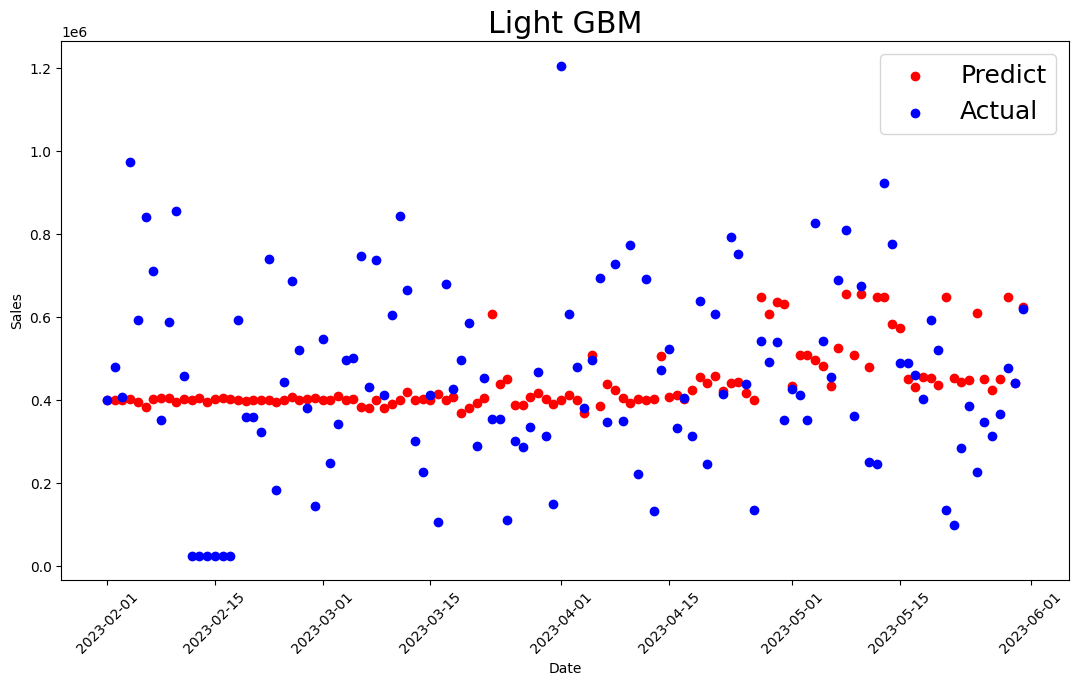

In [31]:
# Create a scatter plot comparing predicted and actual sales using LightGBM
plot_predictions(y_test.index, y_test_pred, y_test, 'Light GBM')

# **Ridge Regression**

In [32]:
# Fit Ridge Regression model to scaled training data
RLR = Ridge().fit(X_train_scaled, y_train)
pred1 = RLR.predict(X_train_scaled)
pred2 = RLR.predict(X_test_scaled)

# Fit Linear Regression model to scaled training data
MLR = LinearRegression().fit(X_train_scaled, y_train)

# Display information about Ridge Regression model
print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Intercept of the Ridge Regression Model was found to be ', RLR.intercept_)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Ridge Regression Model was found to be  633740.4391823839


In [33]:
# Calculate and display evaluation metrics for the Ridge Regression model on the training data
calculate_metrics(y_train, pred1)

Mean Absolute Error (MAE): 312355.611785141
Mean Absolute Percentage Error (MAPE): 0.6038379288361951
R-squared (R2): 0.3578424376188719


In [34]:
# Calculate and display evaluation metrics for the Ridge Regression model on the testing data
calculate_metrics(y_test, pred2)

Mean Absolute Error (MAE): 331578.21965675335
Mean Absolute Percentage Error (MAPE): 1.6198742329517646
R-squared (R2): -1.9957503752599757


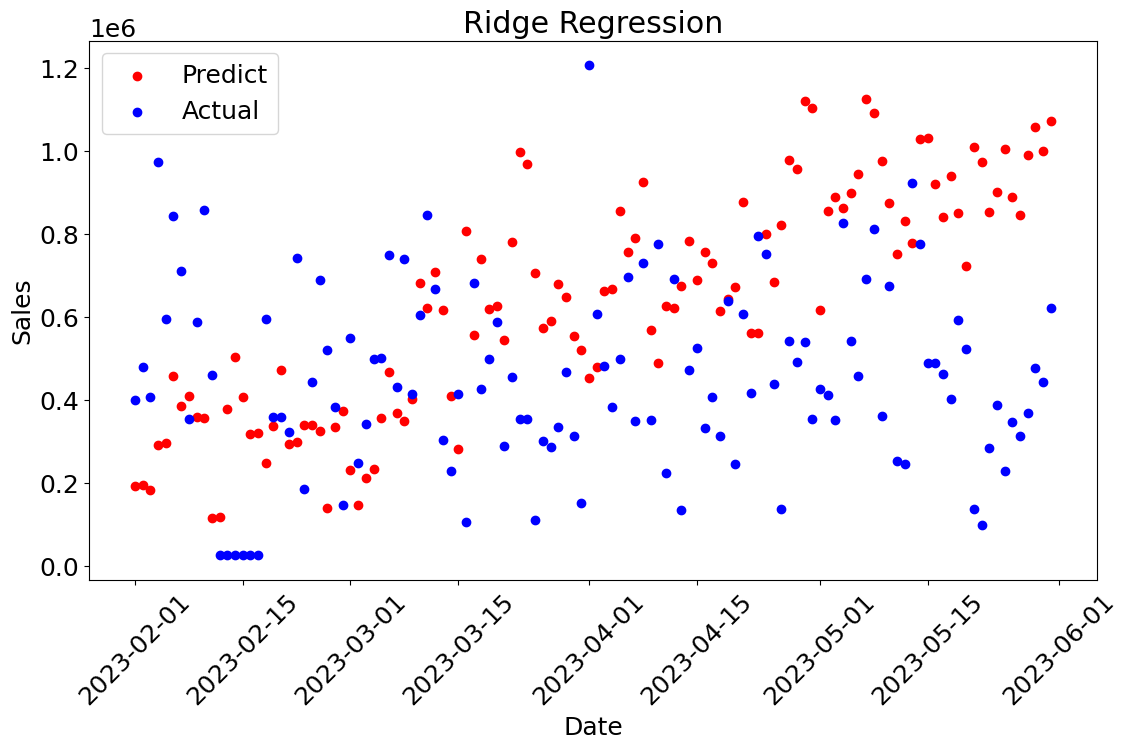

In [35]:
# Create a scatter plot comparing predicted and actual sales using Ridge Regression
plot_predictions(y_test.index, pred2, y_test, 'Ridge Regression')

# **LSTM**

In [36]:
# Create a StandardScaler for Normalize
scaler = StandardScaler()

# Fit the scaler on the training data and transform the dataset
df_for_training_scaled = scaler.fit_transform(train_df)

In [37]:
trainX = []
trainY = []

n_future = 3   # Number of days we want to look into the future based on the past days.
n_past = 14    # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:train_df.shape[1]])   # Using all columns as features
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])    # Using the 1st column as the target

In [38]:
# Convert the lists trainX and trainY into NumPy arrays

trainX, trainY = np.array(trainX), np.array(trainY)

In [39]:
# Let's build the LSTM Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mae')

In [40]:
# Display a summary of the model's architecture and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
27/27 [==============================] - 10s 51ms/step - loss: 0.5619 - val_loss: 0.4096
Epoch 2/100
27/27 [==============================] - 0s 18ms/step - loss: 0.4867 - val_loss: 0.3563
Epoch 3/100
27/27 [==============================] - 1s 19ms/step - loss: 0.4893 - val_loss: 0.3628
Epoch 4/100
27/27 [==============================] - 0s 17ms/step - loss: 0.4736 - val_loss: 0.3519
Epoch 5/100
27/27 [==============================] - 0s 18ms/step - loss: 0.4744 - val_loss: 0.3519
Epoch 6/100
27/27 [==============================] - 0s 18ms/step - loss: 0.4812 - val_loss: 0.3615
Epoch 7/100
27/27 [==============================] - 1s 19ms/step - loss: 0.4760 - val_loss: 0.3538
Epoch 8/100
27/27 [==============================] - 1s 19ms/step - loss: 0.4603 - val_loss: 0.3508
Epoch 9/100
27/27 [==============================] - 1s 20ms/step - loss: 0.4635 - val_loss: 0.3559
Epoch 10/100
27/27 [==============================] - 1s 28ms/step - loss: 0.4578 - val_loss: 0.354

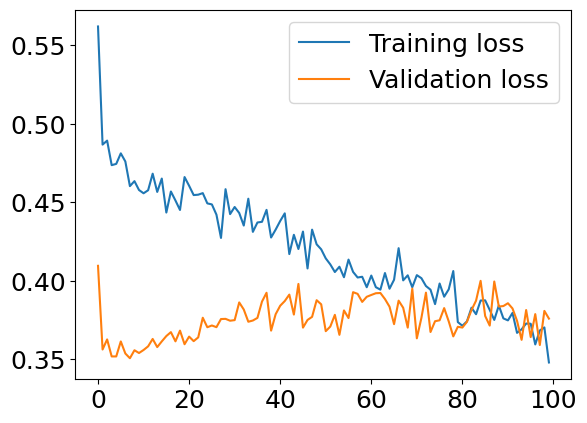

In [41]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [42]:
# Convert the index of X_train into a DatetimeIndex object
train_dates = pd.to_datetime(X_train.index)

In [43]:
# Redefine n_future to extend prediction dates beyond the original dataset
n_future = 120

# Generate a list of forecast period dates
forecast_period_dates = pd.date_range(
    list(train_dates)[-1] + pd.DateOffset(days=1),
    periods=n_future,
    freq='1d'
).tolist()

print(forecast_period_dates)

[Timestamp('2023-02-01 00:00:00', freq='D'), Timestamp('2023-02-02 00:00:00', freq='D'), Timestamp('2023-02-03 00:00:00', freq='D'), Timestamp('2023-02-04 00:00:00', freq='D'), Timestamp('2023-02-05 00:00:00', freq='D'), Timestamp('2023-02-06 00:00:00', freq='D'), Timestamp('2023-02-07 00:00:00', freq='D'), Timestamp('2023-02-08 00:00:00', freq='D'), Timestamp('2023-02-09 00:00:00', freq='D'), Timestamp('2023-02-10 00:00:00', freq='D'), Timestamp('2023-02-11 00:00:00', freq='D'), Timestamp('2023-02-12 00:00:00', freq='D'), Timestamp('2023-02-13 00:00:00', freq='D'), Timestamp('2023-02-14 00:00:00', freq='D'), Timestamp('2023-02-15 00:00:00', freq='D'), Timestamp('2023-02-16 00:00:00', freq='D'), Timestamp('2023-02-17 00:00:00', freq='D'), Timestamp('2023-02-18 00:00:00', freq='D'), Timestamp('2023-02-19 00:00:00', freq='D'), Timestamp('2023-02-20 00:00:00', freq='D'), Timestamp('2023-02-21 00:00:00', freq='D'), Timestamp('2023-02-22 00:00:00', freq='D'), Timestamp('2023-02-23 00:00:00'

In [44]:
# Use the model to predict future sales values for the extended forecast period
forecast = model.predict(trainX[-n_future:])

4/4 [==============================] - 0s 8ms/step


In [45]:
# Perform inverse scaling
forecast_copies = np.repeat(forecast, df_for_training_scaled.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [46]:
# Calculate and display evaluation metrics for the model's predictions on the extended forecast period
calculate_metrics(y_test, y_pred_future)

Mean Absolute Error (MAE): 201194.90677083333
Mean Absolute Percentage Error (MAPE): 1.669831721510499
R-squared (R2): -0.26917719014061836


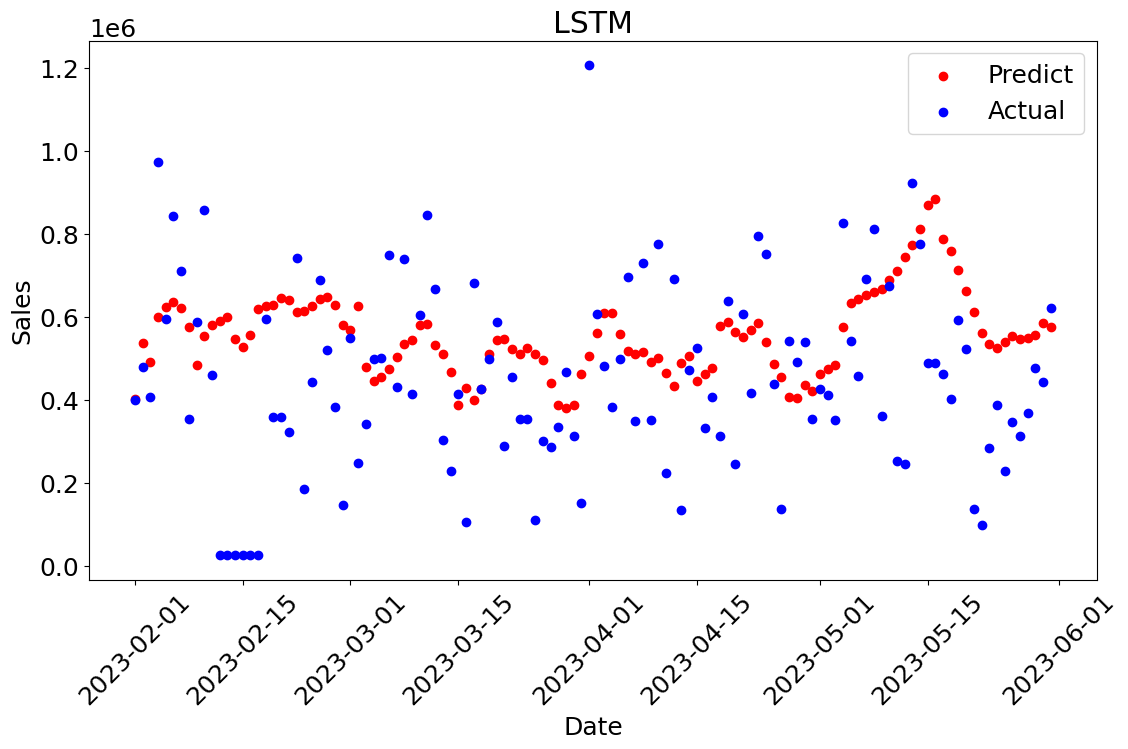

In [47]:
# Create a scatter plot comparing predicted and actual sales using LSTM
plot_predictions(y_test.index, y_pred_future, y_test, 'LSTM')

# **Simple RNN**

In [48]:
# Let's build the simple RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(SimpleRNN(50, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

In [49]:
# Compile the model using the Adam optimizer and MAE loss function
model.compile(optimizer='adam', loss='mae')

# Display a summary of the model's architecture and parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 64)            4608      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5750      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,409
Trainable params: 10,409
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
27/27 [==============================] - 3s 22ms/step - loss: 0.6392 - val_loss: 0.3668
Epoch 2/200
27/27 [==============================] - 0s 11ms/step - loss: 0.5114 - val_loss: 0.4829
Epoch 3/200
27/27 [==============================] - 0s 10ms/step - loss: 0.4670 - val_loss: 0.3579
Epoch 4/200
27/27 [==============================] - 0s 10ms/step - loss: 0.4359 - val_loss: 0.3991
Epoch 5/200
27/27 [==============================] - 0s 12ms/step - loss: 0.4140 - val_loss: 0.4125
Epoch 6/200
27/27 [==============================] - 0s 11ms/step - loss: 0.3994 - val_loss: 0.3682
Epoch 7/200
27/27 [==============================] - 0s 12ms/step - loss: 0.3963 - val_loss: 0.3604
Epoch 8/200
27/27 [==============================] - 0s 16ms/step - loss: 0.3554 - val_loss: 0.3926
Epoch 9/200
27/27 [==============================] - 0s 15ms/step - loss: 0.3577 - val_loss: 0.3643
Epoch 10/200
27/27 [==============================] - 0s 16ms/step - loss: 0.3331 - val_loss: 0.3781

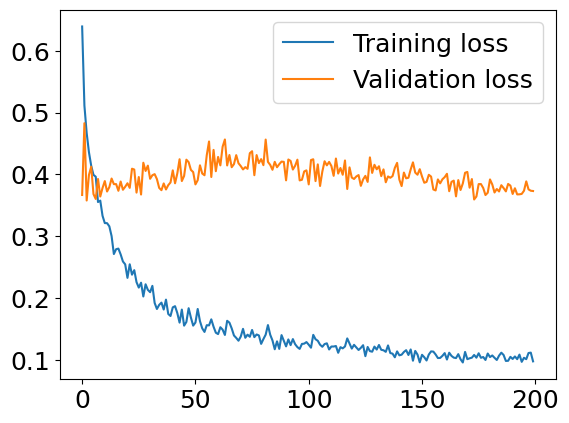

In [50]:
# fit the model
history = model.fit(trainX, trainY, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [51]:
# Predict future sales
forecast = model.predict(trainX[-n_future:])

4/4 [==============================] - 0s 5ms/step


In [52]:
# Perform inverse scaling
forecast_copies = np.repeat(forecast, train_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [53]:
# Calculate and display evaluation metrics for the model's predictions on the extended forecast period
calculate_metrics(y_test, y_pred_future)

Mean Absolute Error (MAE): 225663.76276041666
Mean Absolute Percentage Error (MAPE): 1.7608103953503578
R-squared (R2): -0.5887806608812733


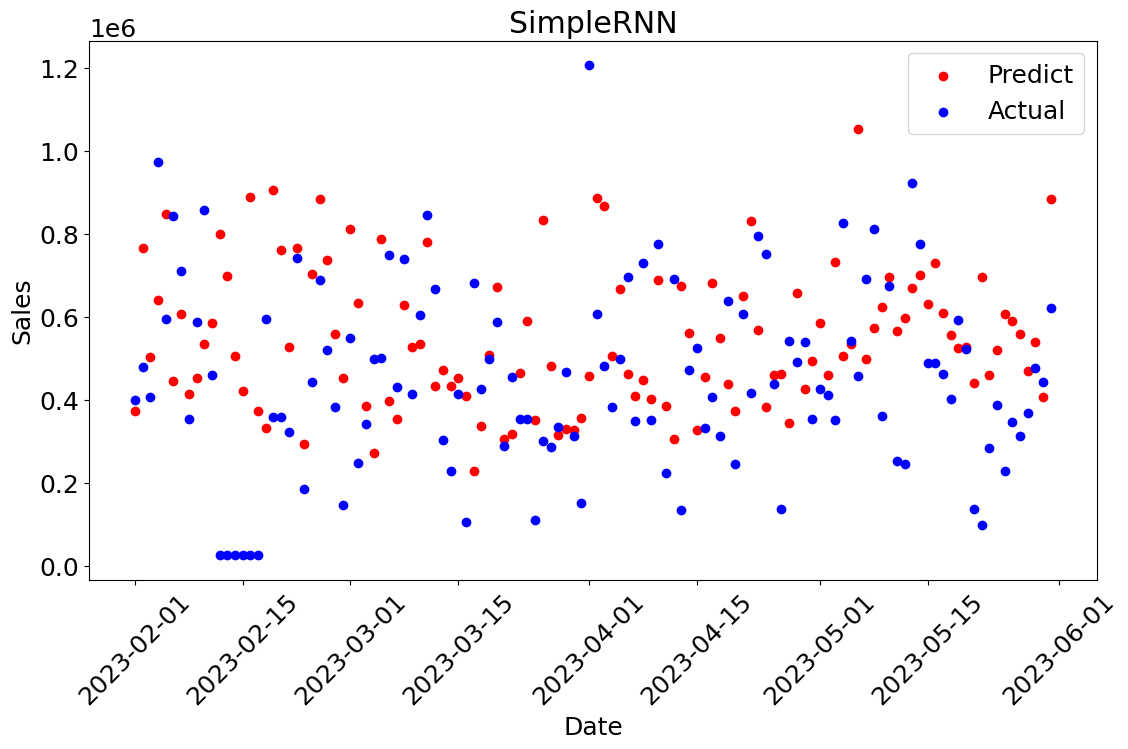

In [54]:
# Create a scatter plot comparing predicted and actual sales using SimpleRNN
plot_predictions(y_test.index, y_pred_future, y_test, 'SimpleRNN')

# **Plotting MAE dll**

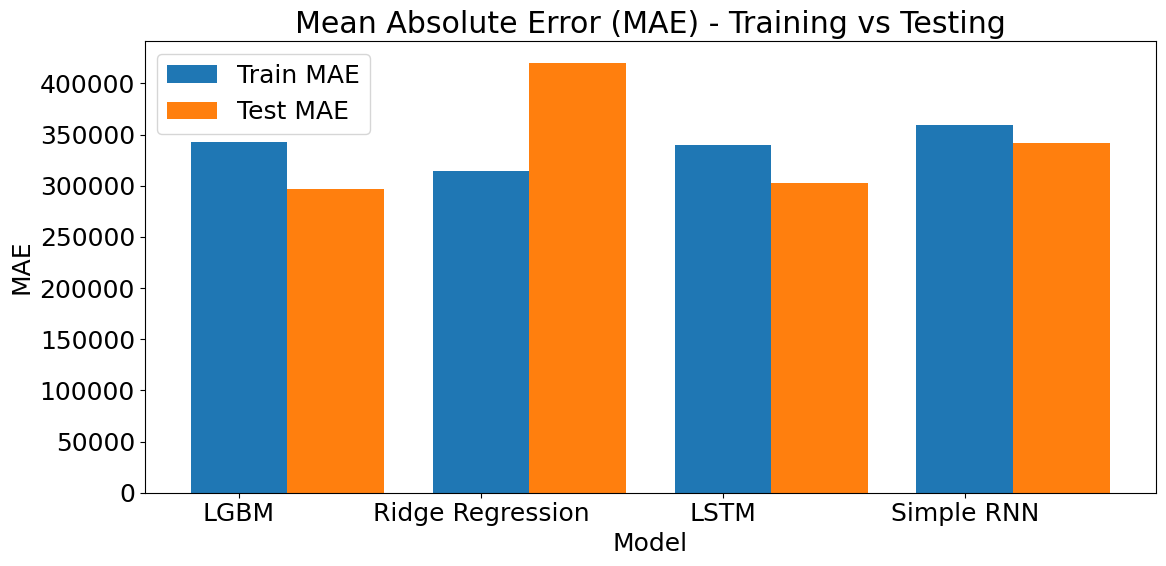

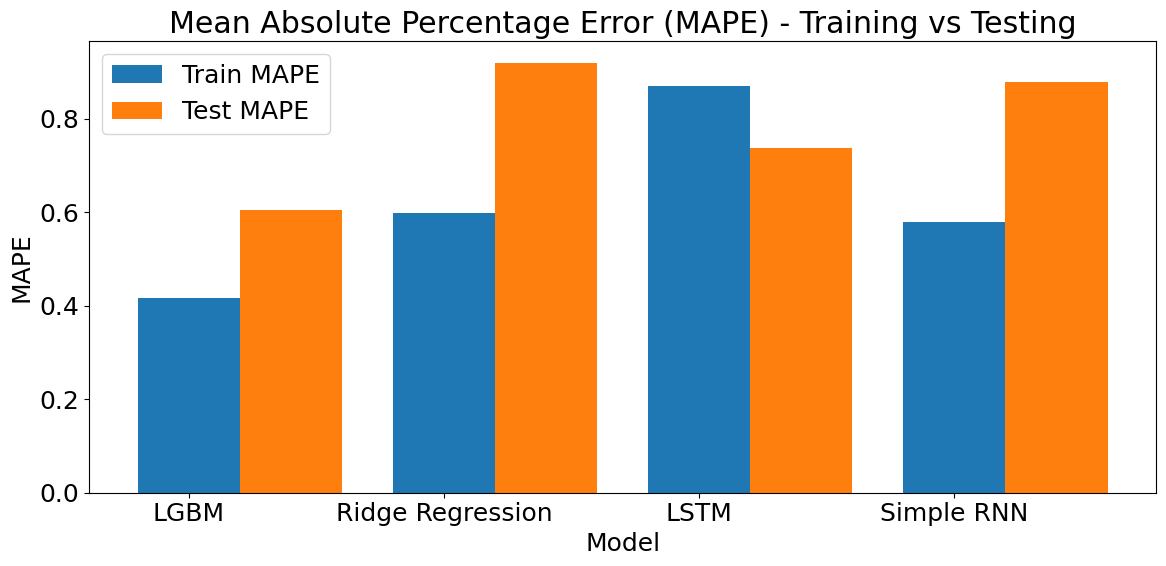

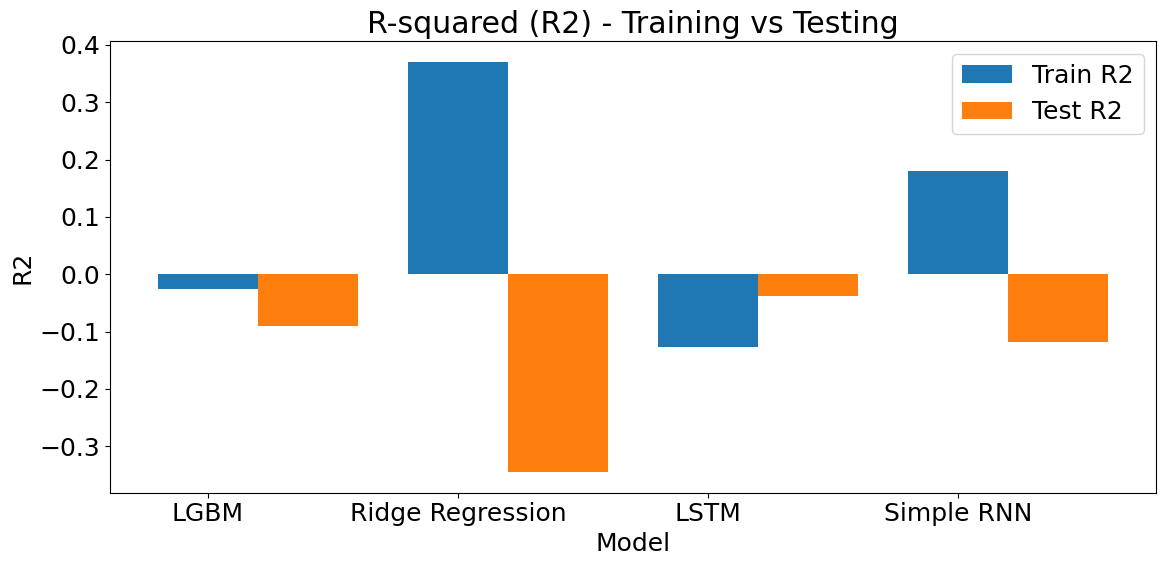

In [55]:
import matplotlib.pyplot as plt

# Define models and corresponding metrics
models = ['LGBM', 'Ridge Regression', 'LSTM', 'Simple RNN']
mae_train = [343023.3142967174, 314830.9621567349, 339501.1788793103, 359231.93572845805]
mae_test = [297234.5304007291, 420173.2161235808, 303052.1206896552, 342275.28965517244]
mape_train = [0.4171142362395731, 0.5989291462498135, 0.8696358490097068, 0.5800636766062893]
mape_test = [0.60553113442702, 0.9194274498400714, 0.7366411603403833, 0.8789345178632064]
r2_train = [-0.025141106089192178, 0.3703708265272809, -0.126892570522966, 0.18083449787385075]
r2_test = [-0.09064548151455187, -0.345173856447192, -0.03805018530310034, -0.11885474147014308]

# Prepare positions for x-axis for each model
x = range(len(models))

# Plot MAE on training and testing
plt.figure(figsize=(12, 6))
plt.bar(x, mae_train, width=0.4, align='center', label='Train MAE')
plt.bar([i + 0.4 for i in x], mae_test, width=0.4, align='center', label='Test MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) - Training vs Testing')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAPE on training and testing
plt.figure(figsize=(12, 6))
plt.bar(x, mape_train, width=0.4, align='center', label='Train MAPE')
plt.bar([i + 0.4 for i in x], mape_test, width=0.4, align='center', label='Test MAPE')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error (MAPE) - Training vs Testing')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# Plot R2 on training and testing
plt.figure(figsize=(12, 6))
plt.bar(x, r2_train, width=0.4, align='center', label='Train R2')
plt.bar([i + 0.4 for i in x], r2_test, width=0.4, align='center', label='Test R2')
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('R-squared (R2) - Training vs Testing')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

In summary, among the evaluated models, the LGBM model demonstrates superior performance in terms of both MAE and MAPE, establishing itself as the most accurate predictor for future sales based on the provided weather data. It is important to note, however, that despite the model's accuracy, all the models encountered difficulties in comprehensively capturing the entire range of data variability. This is evident from the negative or close-to-zero R-squared values, suggesting that there are underlying factors beyond weather variables influencing sales trends.

Therefore, future projects should consider incorporating additional factors beyond point of sales, such as item-specific daily sales, daily foot traffic, and other relevant variables. This holistic approach, encompassing a broader spectrum of contributing factors, is likely to enhance the predictive capabilities and overall accuracy of the models. Further iterations and refinement, including feature engineering, would be beneficial in realizing these improvements and facilitating more accurate sales forecasts for the business.